In [5]:
%matplotlib inline


# OT for domain adaptation

This example introduces a domain adaptation in a 2D setting and the 4 OTDA
approaches currently supported in POT.


In [64]:
# Authors: Remi Flamary <remi.flamary@unice.fr>
#          Stanislas Chambon <stan.chambon@gmail.com>
#
# License: MIT License

from math import floor, exp
import numpy as np
from numpy.random import poisson
import scipy as sp
from sklearn.utils import check_random_state
import theano.tensor as T
import matplotlib.pylab as pl
import ot
import pandas as pd
from sklearn import svm
from sklearn.metrics import accuracy_score

In [115]:
def make_data_classif(dataset, n, nz=.5, theta=0, p=.5, random_state=None, **kwargs):
    """Dataset generation for classification problems

    Parameters
    ----------
    dataset : str
        type of classification problem (see code)
    n : int
        number of training samples
    nz : float
        noise level (>0)
    p : float
        proportion of one class in the binary setting
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.

    Returns
    -------
    X : ndarray, shape (n, d)
        `n` observation of size `d`
    y : ndarray, shape (n,)
        labels of the samples.
    """
    generator = check_random_state(random_state)

    if dataset.lower() == '3gauss':
        y = np.floor((np.arange(n) * 1.0 / n * 3)) + 1
        x = np.zeros((n, 2))
        # class 1
        x[y == 1, 0] = -1.
        x[y == 1, 1] = -1.
        x[y == 2, 0] = -1.
        x[y == 2, 1] = 1.
        x[y == 3, 0] = 1.
        x[y == 3, 1] = 0

        x[y != 3, :] += 1.5 * nz * generator.randn(sum(y != 3), 2)
        x[y == 3, :] += 2 * nz * generator.randn(sum(y == 3), 2)

    elif dataset.lower() == '3gauss2':
        y = np.floor((np.arange(n) * 1.0 / n * 3)) + 1
        x = np.zeros((n, 2))
        y[y == 4] = 3
        # class 1
        x[y == 1, 0] = -2.
        x[y == 1, 1] = -2.
        x[y == 2, 0] = -2.
        x[y == 2, 1] = 2.
        x[y == 3, 0] = 2.
        x[y == 3, 1] = 0

        x[y != 3, :] += nz * generator.randn(sum(y != 3), 2)
        x[y == 3, :] += 2 * nz * generator.randn(sum(y == 3), 2)

    elif dataset.lower() == '2gauss':
        y = np.floor((np.arange(n) * 1.0 / n * 2)) + 1
        x = np.zeros((n, 2))
        # class 1
        x[y == 1, 0] = -0.5
        x[y == 1, 1] = -0.5
        x[y == 2, 0] = -0.5
        x[y == 2, 1] = 0.5
        x[y > 0, :] += 2 * nz * generator.randn(sum(y > 0), 2)
    elif dataset.lower() == '2gauss2':
        y = np.floor((np.arange(n) * 1.0 / n * 2)) + 1
        x = np.zeros((n, 2))
        # class 1
        x[y == 1, 0] = -2.
        x[y == 1, 1] = -2.
        x[y == 2, 0] = -2.
        x[y == 2, 1] = 2.
        x[y > 0, :] += 2 * nz * generator.randn(sum(y > 0), 2)
        
    return x, y.astype(int)

## Generate data



In [122]:
n_source_samples = 150
n_target_samples = 150

source_reps, source_desired_labels = make_data_classif('2gauss', n_source_samples)
target_reps, target_desired_labels = make_data_classif('2gauss2', n_target_samples)

# Sinkhorn Transport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1)
ot_sinkhorn.fit(Xs=source_reps, Xt=target_reps)
trans_source_reps = ot_sinkhorn.transform(Xs=source_reps)

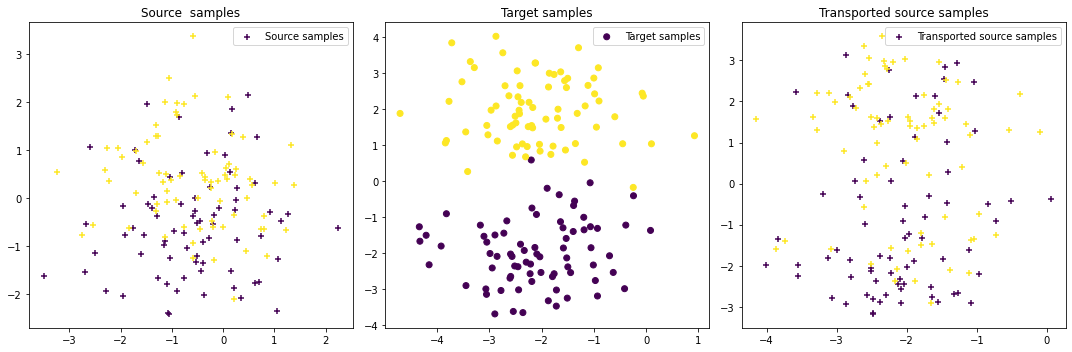

In [123]:
pl.figure(1, figsize=(15, 5))
pl.subplot(1, 3, 1)
pl.scatter(source_reps[:, 0], source_reps[:, 1], c=source_desired_labels, marker='+', label='Source samples')
# pl.xticks([])
# pl.yticks([])
pl.legend(loc=0)
pl.title('Source  samples')

pl.subplot(1, 3, 2)
pl.scatter(target_reps[:, 0], target_reps[:, 1], c=target_desired_labels, marker='o', label='Target samples')
# pl.xticks([])
# pl.yticks([])
pl.legend(loc=0)
pl.title('Target samples')
pl.tight_layout()

pl.subplot(1, 3, 3)
pl.scatter(trans_source_reps[:, 0], trans_source_reps[:, 1], c=source_desired_labels, marker='+', label='Transported source samples')
# pl.xticks([])
# pl.yticks([])
pl.legend(loc=0)
pl.title('Transported source samples')
pl.tight_layout()

In [124]:
clf = svm.SVC()
clf.fit(target_reps, target_desired_labels)
target_pred_labels = clf.predict(target_reps)
source_pred_labels = clf.predict(source_reps)
trans_source_pred_labels = clf.predict(trans_source_reps)
print(accuracy_score(target_desired_labels, target_pred_labels))
print(accuracy_score(source_desired_labels, source_pred_labels))
print(accuracy_score(source_desired_labels, trans_source_pred_labels))

0.9866666666666667
0.6866666666666666
0.72


In [128]:
""" 
For 3 classes
"""

n_source_samples = 150
n_target_samples = 150

source_reps, source_desired_labels = make_data_classif('3gauss', n_source_samples)
target_reps, target_desired_labels = make_data_classif('3gauss2', n_target_samples)

# Sinkhorn Transport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1)
ot_sinkhorn.fit(Xs=source_reps, Xt=target_reps)
trans_source_reps = ot_sinkhorn.transform(Xs=source_reps)

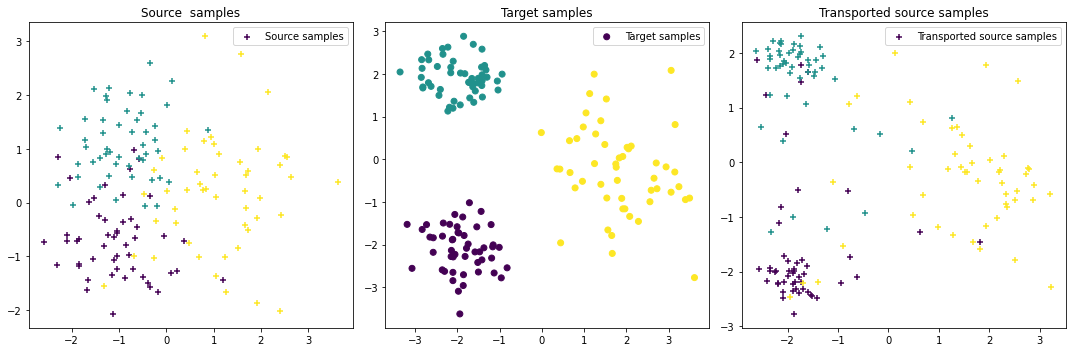

In [129]:
pl.figure(1, figsize=(15, 5))
pl.subplot(1, 3, 1)
pl.scatter(source_reps[:, 0], source_reps[:, 1], c=source_desired_labels, marker='+', label='Source samples')
# pl.xticks([])
# pl.yticks([])
pl.legend(loc=0)
pl.title('Source  samples')

pl.subplot(1, 3, 2)
pl.scatter(target_reps[:, 0], target_reps[:, 1], c=target_desired_labels, marker='o', label='Target samples')
# pl.xticks([])
# pl.yticks([])
pl.legend(loc=0)
pl.title('Target samples')
pl.tight_layout()

pl.subplot(1, 3, 3)
pl.scatter(trans_source_reps[:, 0], trans_source_reps[:, 1], c=source_desired_labels, marker='+', label='Transported source samples')
# pl.xticks([])
# pl.yticks([])
pl.legend(loc=0)
pl.title('Transported source samples')
pl.tight_layout()

In [127]:
clf = svm.SVC()
clf.fit(target_reps, target_desired_labels)
target_pred_labels = clf.predict(target_reps)
source_pred_labels = clf.predict(source_reps)
trans_source_pred_labels = clf.predict(trans_source_reps)
print(accuracy_score(target_desired_labels, target_pred_labels))
print(accuracy_score(source_desired_labels, source_pred_labels))
print(accuracy_score(source_desired_labels, trans_source_pred_labels))

0.9933333333333333
0.7933333333333333
0.8266666666666667


In [ ]:
""" 
Generate features
"""

In [5]:
def sample_vae_params(l, feature_len):
    """ 
    Sample deep patient parameters necessary for reconstructing the data \
        from the representation per domain
    
    :param int l: the embedding dimension
    :param int feature_len: the feature cardinality 

    return 
        - wp, dimension is l x (# of visible units) (see da.py)
        - bp, dimension is 1 x (# of visible units) (see da.py)
    """
    wp = np.random.uniform(low=-0.5, high=0.5, size=[l, feature_len])
    bp = np.random.uniform(size=[1, feature_len])
    return wp, bp

In [6]:
embedding_dim = 2
target_feature_len = 4
source_feature_len = 4
target_wp, target_bp = sample_vae_params(embedding_dim, target_feature_len)
source_wp, source_bp = sample_vae_params(embedding_dim, source_feature_len)

In [25]:
def gen_features(wp, bp, embeddings):
    """ 
    Generate features based on embeddings, including
    - transform
    - denormalize
    """
    normalized_features = T.nnet.sigmoid(T.dot(embeddings, wp) + bp).eval()
    # print("normalized_feature is:", normalized_features)
    denormalized_features = np.empty(shape=normalized_features.shape)

    sigma = 10 # TODO: can also simulate this parameter
    for i in range(len(normalized_features)):
        denormalized_features[i] = [feature*sigma for feature in normalized_features[i]]

    normalized_min = normalized_features.min()
    normalized_incre = 0
    if normalized_min < 0:
        normalized_incre = -normalized_min
    for i in range(len(denormalized_features)):
        denormalized_features[i] = [int(feature+normalized_incre) for feature in denormalized_features[i]]

    return denormalized_features

In [26]:
target_features = gen_features(target_wp, target_bp, target_reps)
source_features = gen_features(source_wp, source_bp, source_reps)

In [31]:
print(target_features.shape)
print(target_desired_labels.shape)
target_features_label = np.append(target_features, target_desired_labels.reshape([target_features.shape[0], 1]), axis=1)
np.savetxt("../outputs/target_feature_label.txt", target_features_label, fmt="%d")

(150, 4)
(150,)


In [32]:
print(source_features.shape)
print(source_desired_labels.shape)
source_features_label = np.append(source_features, source_desired_labels.reshape([source_features.shape[0], 1]), axis=1)
np.savetxt("../outputs/source_features_label.txt", source_features_label, fmt="%d")

(150, 4)
(150,)


In [7]:
def gen_labels(feature_list, W, D):
    """ 
    Generate labels for all features in a domain, according to simulation 2 scheme

    """

    def sigmoid(x):
        """ 
        Sigmoid function
        """
        return 1 / (1 + exp(-x))
    
    def feature2ind(features):
        """ 
        Convert features to feature vector (indicator vector), per patient

        :param list[int] features: features with the actual feature code

        return
            - list[int]: a feature vector encoded by feature indicators
        """
        ind_vector = np.zeros(D)
        for feature in features:
            ind_vector[int(feature)] = 1
        return ind_vector

    # D = int(feature_list.max()+1) # set D, the total number of features, to be the number of features exist in feature_list
    # print("D is:", D)
    num_patient = feature_list.shape[0]
    # W = np.random.normal(size=D) # sample weights
    # W = [max(0, W_k) for W_k in W] # only sample positive weights
    X = []
    Y = []

    for i in range(num_patient):
        X_i = feature2ind(feature_list[i])
        for k in range(len(X_i)):
            if X_i[k] > 0:
                X_i[k] = 1 # dominant effect
        X.append(X_i)
        lambda_i= np.sum(np.multiply(W, X_i))
        Y_i = poisson(lam = lambda_i)
        Y.append(Y_i)
    return Y

## Instantiate the different transport algorithms and fit them



In [30]:
# EMD Transport
ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=Xs, Xt=Xt)

# Sinkhorn Transport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn.fit(Xs=Xs, Xt=Xt)

# Sinkhorn Transport with Group lasso regularization
ot_lpl1 = ot.da.SinkhornLpl1Transport(reg_e=1e-1, reg_cl=1e0)
ot_lpl1.fit(Xs=Xs, ys=ys, Xt=Xt)

# Sinkhorn Transport with Group lasso regularization l1l2
ot_l1l2 = ot.da.SinkhornL1l2Transport(reg_e=1e-1, reg_cl=2e0, max_iter=20,
                                      verbose=True)
ot_l1l2.fit(Xs=Xs, ys=ys, Xt=Xt)

# transport source samples onto target samples
transp_Xs_emd = ot_emd.transform(Xs=Xs)
transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=Xs)
transp_Xs_lpl1 = ot_lpl1.transform(Xs=Xs)
transp_Xs_l1l2 = ot_l1l2.transform(Xs=Xs)

/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|8.435968e+00|0.000000e+00|0.000000e+00
    1|1.762678e+00|3.785881e+00|6.673290e+00
    2|1.556720e+00|1.323026e-01|2.059581e-01
    3|1.503249e+00|3.557052e-02|5.347134e-02
    4|1.486696e+00|1.113384e-02|1.655264e-02
    5|1.477969e+00|5.905028e-03|8.727447e-03
    6|1.473993e+00|2.697258e-03|3.975739e-03
    7|1.470851e+00|2.136464e-03|3.142419e-03
    8|1.469111e+00|1.184106e-03|1.739583e-03
    9|1.468060e+00|7.158836e-04|1.050960e-03
   10|1.466708e+00|9.221222e-04|1.352484e-03
   11|1.465724e+00|6.710465e-04|9.835689e-04
   12|1.465650e+00|5.042792e-05|7.390969e-05
   13|1.464529e+00|7.655235e-04|1.121131e-03
   14|1.464256e+00|1.863732e-04|2.728981e-04
   15|1.463326e+00|6.354836e-04|9.299198e-04
   16|1.462836e+00|3.351192e-04|4.902244e-04
   17|1.462642e+00|1.323967e-04|1.936489e-04
   18|1.462572e+00|4.793196e-05|7.010395e-05
   19|1.462230e+00|2.343180e-04|3.426267e-04
It. 

## Fig 1 : plots source and target samples



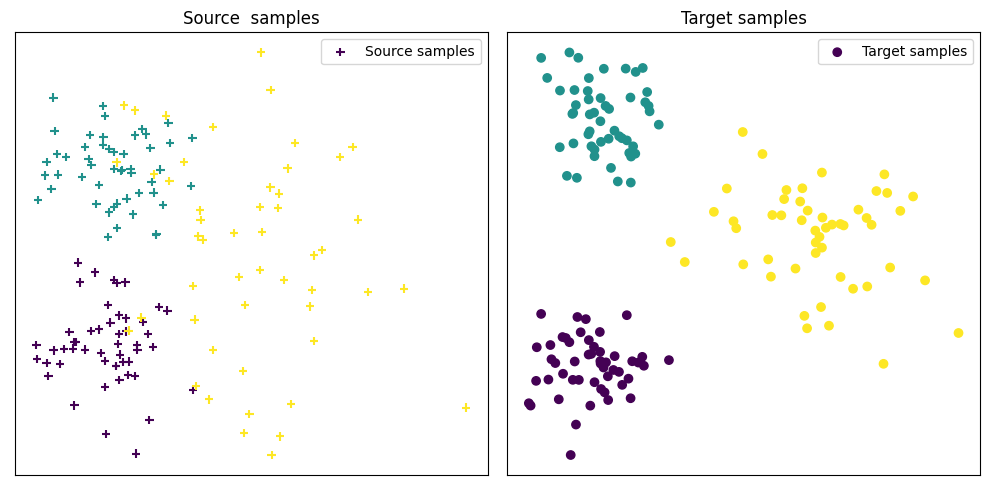

In [31]:
pl.figure(1, figsize=(10, 5))
pl.subplot(1, 2, 1)
pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
pl.xticks([])
pl.yticks([])
pl.legend(loc=0)
pl.title('Source  samples')

pl.subplot(1, 2, 2)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
pl.xticks([])
pl.yticks([])
pl.legend(loc=0)
pl.title('Target samples')
pl.tight_layout()

## Fig 2 : plot optimal couplings and transported samples



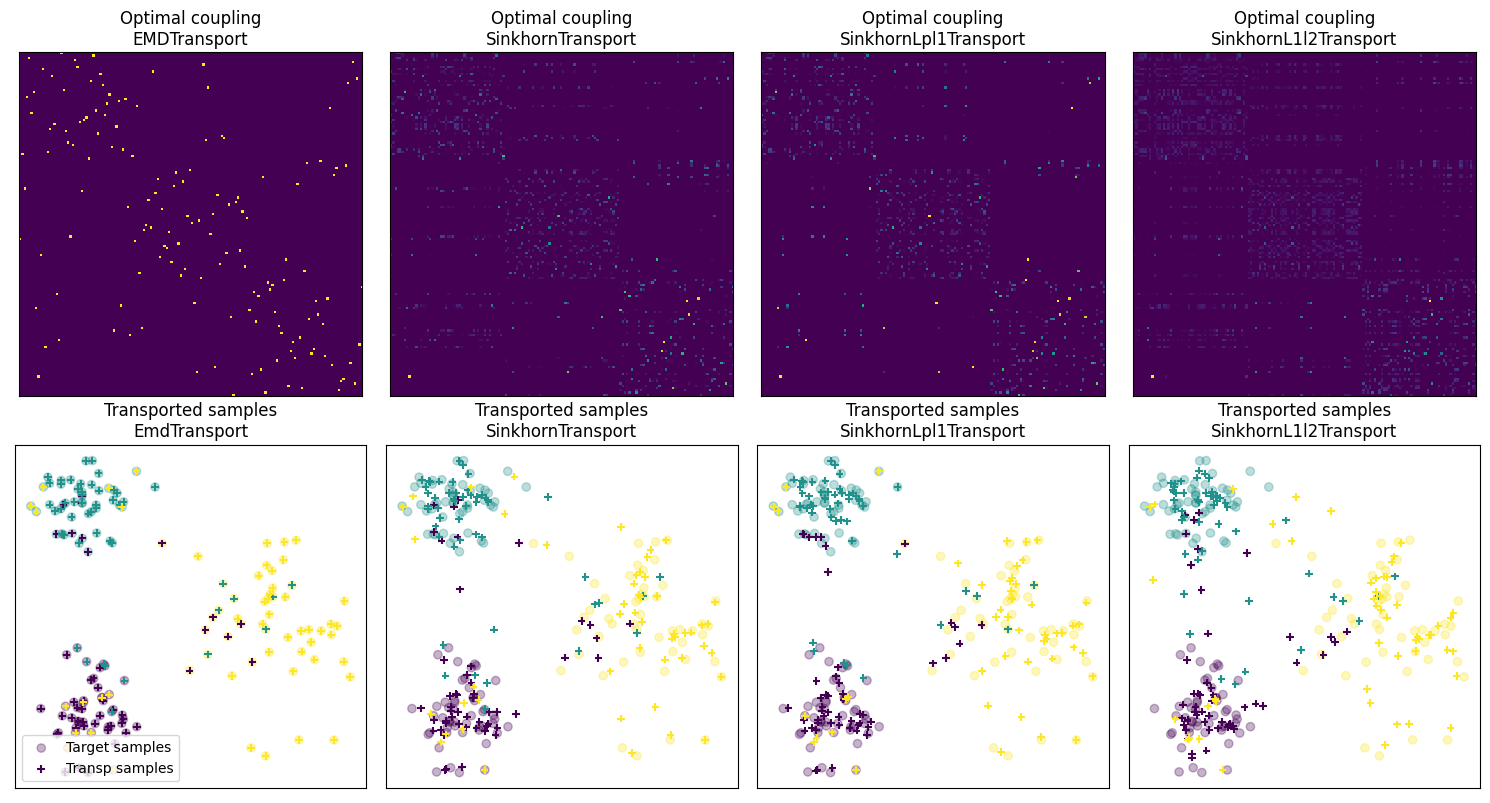

In [26]:
param_img = {'interpolation': 'nearest'}

pl.figure(2, figsize=(15, 8))
pl.subplot(2, 4, 1)
pl.imshow(ot_emd.coupling_, **param_img)
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nEMDTransport')

pl.subplot(2, 4, 2)
pl.imshow(ot_sinkhorn.coupling_, **param_img)
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nSinkhornTransport')

pl.subplot(2, 4, 3)
pl.imshow(ot_lpl1.coupling_, **param_img)
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nSinkhornLpl1Transport')

pl.subplot(2, 4, 4)
pl.imshow(ot_l1l2.coupling_, **param_img)
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nSinkhornL1l2Transport')

pl.subplot(2, 4, 5)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.3)
pl.scatter(transp_Xs_emd[:, 0], transp_Xs_emd[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.xticks([])
pl.yticks([])
pl.title('Transported samples\nEmdTransport')
pl.legend(loc="lower left")

pl.subplot(2, 4, 6)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.3)
pl.scatter(transp_Xs_sinkhorn[:, 0], transp_Xs_sinkhorn[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.xticks([])
pl.yticks([])
pl.title('Transported samples\nSinkhornTransport')

pl.subplot(2, 4, 7)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.3)
pl.scatter(transp_Xs_lpl1[:, 0], transp_Xs_lpl1[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.xticks([])
pl.yticks([])
pl.title('Transported samples\nSinkhornLpl1Transport')

pl.subplot(2, 4, 8)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.3)
pl.scatter(transp_Xs_l1l2[:, 0], transp_Xs_l1l2[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.xticks([])
pl.yticks([])
pl.title('Transported samples\nSinkhornL1l2Transport')
pl.tight_layout()

pl.show()